In [ ]:
# Audio Tokenzation Tutorial with Vector Quantization
# Source : Ravin Kumar : https://ravinkumar.com/GenAiGuidebook/audio/audio_tokenization_in_practice.html#audio-tokenization-tutorial-vq-tokenization
import librosa 
import soundfile as sf
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np


In [27]:
def load_and_preprocess_audio(file_path, sr=None, n_mels=80):
    ''' Take file path, sampling rate and number of mel bands
        return log mel spectogram 
    '''
    y, sr = librosa.load(file_path, sr=sr)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec)
    return y, sr, log_mel_spec

def visualize_waveform(y,sr):
    ''' Take audio time series (np.ndarray) and plot waweform
    '''
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Audio Waveform')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()
    
def visualize_spectogram(mel_features,sr):
    ''' Visualize Spectogram given mel features
    '''
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mel_features, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%2.0f dB')
    plt.title('Mel Spectrogram')
    plt.show()
    
def vq_tokenize(features,n_tokens=512):
    # Flattend 2D features
    flat_feature = features.T.flatten()
    
    # Reshape to 2D array
    reshaped_features = flat_feature.reshape(-1,1)
    
    # K-means clustering
    kmeans = KMeans(n_clusters=n_tokens,random_state=42)
    kmeans.fit(reshaped_features)
    
    # Cluster assignments 
    tokens = kmeans.predict(reshaped_features)
    
    # Reshape token back to original shape (time,frequency)
    tokens = tokens.reshape(features.shape[1],-1)
    
    return tokens,kmeans 

def visualize_token_representation(tokens):
    plt.figure(figsize=(12, 4))
    plt.imshow(tokens, aspect='auto', interpolation='nearest', cmap='viridis')
    plt.colorbar(label='Token ID')
    plt.title('Tokenized Audio')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()
    
def vq_detokenize(tokens,kmeans):
    # Flatten the tokens
    flattened_tokens = tokens.flatten()
        
    # Reconstruct feature using centroids (Generalization)
    reconstructed_features = kmeans.cluster_centers_[flattened_tokens]

    # Reshape back to original mel spectorgram shape 
    reconstructed_features = reconstructed_features.reshape(tokens.shape[0],tokens.shape[1],-1)
    
    # Remove the unnecessary dimension
    return reconstructed_features.squeeze().T


def token_distribution(tokens):
    token_counts = np.bincount(tokens.flatten())
    # Get the indices of min and max frequency tokens 
    min_token_id = np.argmin(token_counts)
    max_token_id = np.argmax(token_counts)

    print(f"Token ID with minimum frequency: {min_token_id} : {token_counts[min_token_id]}")
    print(f"Token ID with maximum frequency: {max_token_id} : {token_counts[max_token_id]}")
    
    
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(token_counts)), token_counts)
    plt.title('Token Frequency Distribution')
    plt.xlabel('Token ID')
    plt.ylabel('Frequency')
    plt.show()
    
def compare_mel_spect(mel_1,mel_2):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    img1 = librosa.display.specshow(mel_1, x_axis='time', y_axis='mel', ax=ax1)
    ax1.set_title('Original Mel Spectrogram')
    fig.colorbar(img1, ax=ax1, format='%2.0f dB')

    img2 = librosa.display.specshow(mel_2, x_axis='time', y_axis='mel', ax=ax2)
    ax2.set_title('Reconstructed Mel Spectrogram')
    fig.colorbar(img2, ax=ax2, format='%2.0f dB')

    plt.tight_layout()
    plt.show()

def detokenize(mel_spec,sr,y,n_iter =10): # Convert from dB scale back to power
    mel_spec = librosa.db_to_power(mel_spec)
    
    # Use librosa's built-in Griffin-Lim implementation
    reconstructed_audio = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_iter=n_iter)
    
    # Trim or pad to match original length
    if len(reconstructed_audio) > len(y):
        reconstructed_audio = reconstructed_audio[:len(y)]
    else:
        reconstructed_audio = np.pad(reconstructed_audio, (0, len(y) - len(reconstructed_audio)))
    return reconstructed_audio

In [4]:
audio_file = librosa.example('trumpet') # Here I'm using a sample audio file from librosa
# audio_file = "path_to_your_audio_file.wav"  # Replace with your audio file path

y, sr, mel_features  = load_and_preprocess_audio(audio_file)

print(f"Mel spectrogram shape: {mel_features.shape}")
print(f"Sampling rate: {sr}")
print(f"Original audio length: {y.shape[0]} samples")

ipd.Audio(y, rate=sr)

Mel spectrogram shape: (80, 230)
Sampling rate: 22050
Original audio length: 117601 samples


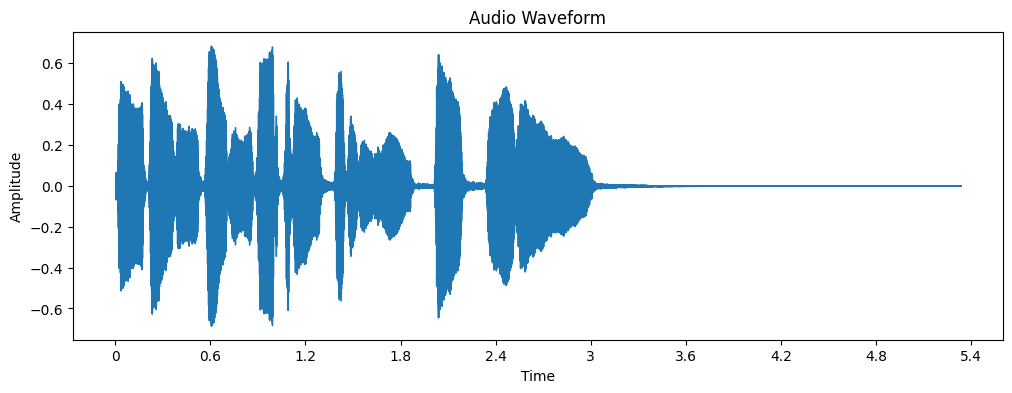

In [5]:
visualize_waveform(y,sr)

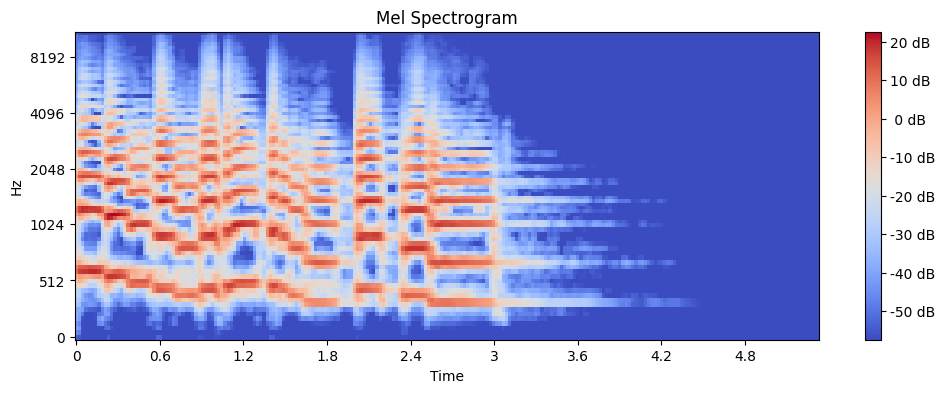

In [6]:
visualize_spectogram(mel_features,sr)

In [10]:
n_tokens = 64 
tokens,kmeans_model = vq_tokenize(mel_features,n_tokens)
print(f"Shape of tokens: {tokens.shape}")
print(f"Number of unique tokens: {len(np.unique(tokens))}")

Shape of tokens: (230, 80)
Number of unique tokens: 64


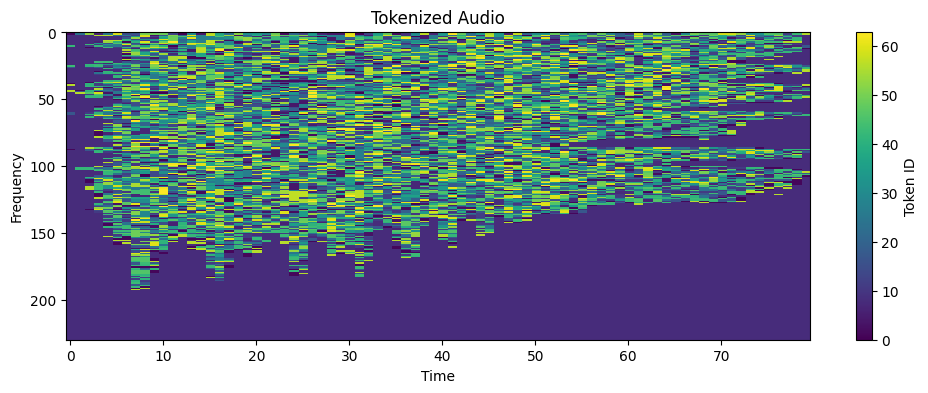

In [12]:
visualize_token_representation(tokens)

Token ID with minimum frequency: 27 : 58
Token ID with maximum frequency: 8 : 7856


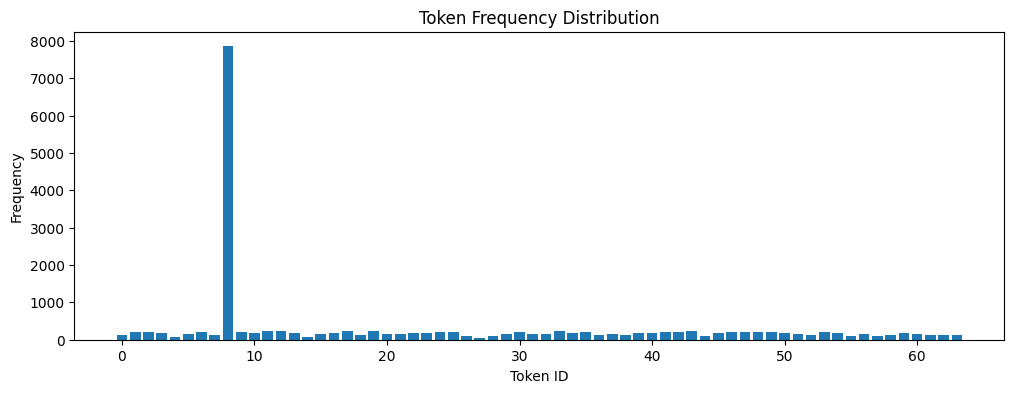

In [16]:
token_distribution(tokens)

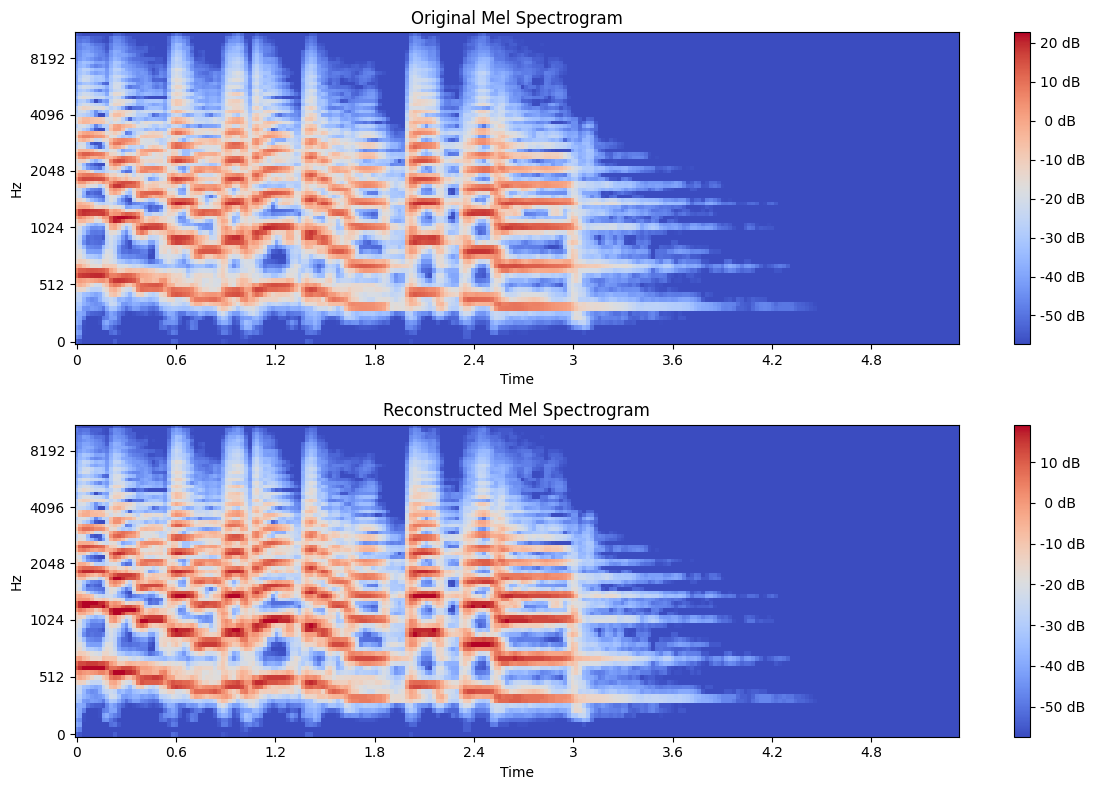

In [22]:
reconstructed_mel = vq_detokenize(tokens, kmeans_model)
compare_mel_spect(mel_features,reconstructed_mel)

In [29]:
# Comparing Original and Reconstructed
audio_file = librosa.example('libri1') 
# audio_file = "path_to_your_audio_file.wav" 
y, sr, mel_features  = load_and_preprocess_audio(audio_file)
n_tokens = 64 
tokens,kmeans_model = vq_tokenize(mel_features,n_tokens)
reconstructed_mel = vq_detokenize(tokens, kmeans_model)
reconstructed_audio = detokenize(reconstructed_mel,sr,y)
print("Original")
ipd.display(ipd.Audio(y,rate=sr))

print("Reconstructed")
ipd.display(ipd.Audio(reconstructed_audio,rate=sr))

Original


Reconstructed
